# [Feature Selection]

In [1]:
!pip install mlxtend

zsh:1: command not found: pip


In [2]:
!pip install lightgbm

zsh:1: command not found: pip


In [3]:
!pip install catboost

zsh:1: command not found: pip


In [4]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
%matplotlib inline
start_time = dt.datetime.now()

## 0. Main elements

- Filter: filter score
- Wrapper: FDR
- But why this final output gives out filter score: The wrapper score (FDR score) is used during the feature selection process to evaluate and rank the importance of the features. The wrapper order you are storing in the final file, 'vars_keep_sorted.csv' reflects the order in which the features were selected by the wrapper method based on the FDR score. This means that while you're not explicitly saving the FDR score for each feature in the final output, the features are already ranked and ordered by their performance (FDR) as a group. The wrapper order inherently represents the effectiveness of the features in improving the model's FDR score.
- But still, why still see filter scores, not the FDR score in the final list: The filter score (e.g., KS score) is included to provide insight into how each feature individually correlates with the target. It's a more straightforward, univariate metric that is easy to interpret, especially for domain experts. The wrapper score (FDR) is used to rank and select the features based on how well they improve the model's performance together, and it’s reflected in the order of selected features, not necessarily as an explicit score in the final output.

## 1. Setting the environment

- num_filter, num_wrapper are the important parameters
- As for the filter, num_filter is usually set at around 10-20% of the original variables. Currently, 'candidate_variables.csv' has 2635 variables. I'm taking only 15% of them, which is 395. 
- As for the wrapper, num_wrapper is first set at about 50. Look for a saturation of the model performance as variables are added. Then run it again with num_wrapper just a bit above this saturation point, not more than twice. -> But this approach takes a long time to run so just set it to 20 from the beginning for this HW.

In [5]:
# set some parameters
num_files = 1
# set num_filter to be about 10 to 20% of the original # variables
num_filter = 263
# set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## 2. Filter

- The filter sorts the independent variables x’s by their ability to predict y by themselves (univariate)
- Use univariate KS score for the filter measure

In [6]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'candidate_variables.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 85264] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 3466] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    
    #Filter starts here
    goods = df[df['Fraud'] == good_label]
    bads = df[df['Fraud'] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20)) 
    #Filter ends here, just some conditions below
    
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
    
filter_score = pd.concat(filter_score_df_list)

********** working on candidate_variables.csv size is (97496, 2635)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
candidate_variables.csv                     variable  filter score
1                      Fraud      1.000000
28           Cardnum_total_3      0.621932
19           Cardnum_total_1      0.619658
10           Cardnum_total_0      0.591318
15           Cardnum_count_1      0.567429
37           Cardnum_total_7      0.564245
24           Cardnum_count_3      0.563356
586         Card_dow_total_7      0.542303
17             Cardnum_max_1      0.532080
33           Cardnum_count_7      0.526897
8              Cardnum_max_0      0.525418
6            Cardnum_count_0      0.516123
595        Card_dow_total_14      0.511203
1577   Cardnum_vdratio_1by30      0.504966
1578   Cardnum_vdratio_1by60      0.502927
26             Cardnum_max_3      0.501170
46          Cardnum_total_14      0.494375
1645  Card_do

In [7]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [8]:
filter_score.head(30)

variable  filter score
0                                   Fraud      1.000000
1                         Cardnum_total_3      0.621932
2                         Cardnum_total_1      0.619658
3                         Cardnum_total_0      0.591318
4                         Cardnum_count_1      0.567429
5                         Cardnum_total_7      0.564245
6                         Cardnum_count_3      0.563356
7                        Card_dow_total_7      0.542303
8                           Cardnum_max_1      0.532080
9                         Cardnum_count_7      0.526897
10                          Cardnum_max_0      0.525418
11                        Cardnum_count_0      0.516123
12                      Card_dow_total_14      0.511203
13                  Cardnum_vdratio_1by30      0.504966
14                  Cardnum_vdratio_1by60      0.502927
15                          Cardnum_max_3      0.501170
16                       Cardnum_total_14      0.494375
17                 Card_dow_vdratio_0by30      0.489227
18                 Card_dow_vdratio_0by60      0.486480
19                         Card_dow_max_7      0.486177
20                  Cardnum_vdratio_1by14      0.485431
21              Cardnum_variability_max_0      0.484245
22                       Card_dow_count_7      0.482384
23                  Cardnum_actual/toal_0      0.479550
24                 Card_dow_vdratio_0by14      0.479086
25              Cardnum_variability_max_1      0.477836
26  Cardnum_unique_count_for_card_state_1      0.476067
27    Cardnum_unique_count_for_card_zip_1      0.474960
28                      Card_dow_total_30      0.474759
29    Cardnum_unique_count_for_Merchnum_1      0.472017

In [9]:
filter_score.tail(10)

variable  filter score
2625           card_merch_unique_count_for_card_state_7      0.000088
2626  Merchnum_desc_Zip_unique_count_for_Merchnum_de...      0.000075
2627           card_merch_unique_count_for_card_state_3      0.000063
2628  Merchdesc_Zip_unique_count_for_Merchdesc_State_14      0.000038
2629   Merchdesc_Zip_unique_count_for_Merchdesc_State_7      0.000038
2630  Card_Merchdesc_Zip_unique_count_for_Merchdesc_...      0.000038
2631          merch_zip_unique_count_for_merch_state_14      0.000025
2632  Merchnum_desc_Zip_unique_count_for_Merchnum_de...      0.000013
2633           merch_zip_unique_count_for_merch_state_7      0.000013
2634              card_merch_unique_count_for_Cardnum_1      0.000000

In [10]:
filter_score.shape

(2635, 2)

## 3. Save the filtered list into csv files

- filter_top: to store the results of the filter step, including all variablels with scores
- vars_keep_filter: to store only the variables selected for further analysis, contains only the names of the variables

In [11]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['Cardnum_total_3', 'Cardnum_total_1', 'Cardnum_total_0', 'Cardnum_count_1', 'Cardnum_total_7', 'Cardnum_count_3', 'Card_dow_total_7', 'Cardnum_max_1', 'Cardnum_count_7', 'Cardnum_max_0', 'Cardnum_count_0', 'Card_dow_total_14', 'Cardnum_vdratio_1by30', 'Cardnum_vdratio_1by60', 'Cardnum_max_3', 'Cardnum_total_14', 'Card_dow_vdratio_0by30', 'Card_dow_vdratio_0by60', 'Card_dow_max_7', 'Cardnum_vdratio_1by14', 'Cardnum_variability_max_0', 'Card_dow_count_7', 'Cardnum_actual/toal_0', 'Card_dow_vdratio_0by14', 'Cardnum_variability_max_1', 'Cardnum_unique_count_for_card_state_1', 'Cardnum_unique_count_for_card_zip_1', 'Card_dow_total_30', 'Cardnum_unique_count_for_Merchnum_1', 'Card_dow_max_14', 'Card_dow_vdratio_0by7', 'Cardnum_vdratio_1by7', 'Cardnum_unique_count_for_card_state_3', 'Cardnum_unique_count_for_card_zip_3', 'Cardnum_total_amount_1_by_60', 'Cardnum_unique_count_for_Merchnum_3', 'Cardnum_actual/toal_1', 'Card_dow_unique_count_for_merch_state_1', 'Card_dow_unique_cou

In [12]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)

## 4. Filtering the dataframe for wrapper analysis

In [13]:
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

Cardnum_total_3  Cardnum_total_1  Cardnum_total_0  Cardnum_count_1  \
Recnum                                                                       
3466            1964.73          1551.02           333.47                3   
3467             834.91           660.87             4.37                2   
3468            8459.94          2904.08           271.93                7   
3469             838.53           664.49             7.99                3   
3470              16.28            16.28            16.28                1   

        Cardnum_total_7  Cardnum_count_3  Card_dow_total_7  Cardnum_max_1  \
Recnum                                                                      
3466            3591.53                7            333.47         930.41   
3467             997.73               34            109.97         656.50   
3468            9674.14               14            271.93        1380.45   
3469            1001.35               35            113.59         656.50   
3470              16.28                1             16.28          16.28   

        Cardnum_count_7  Cardnum_max_0  ...  Cardnum_actual/avg_0  \
Recnum                                  ...                         
3466                  9         333.47  ...              1.000000   
3467                 72           4.37  ...              1.000000   
3468                 17         271.93  ...              1.000000   
3469                 73           4.37  ...              0.906133   
3470                  1          16.28  ...              1.000000   

        Card_Merchnum_Zip_total_0  card_merch_max_0  merch_state_max_3  \
Recnum                                                                   
3466                       333.47            333.47             333.47   
3467                         4.37              4.37              27.00   
3468                       271.93            271.93             278.73   
3469                         7.99              4.37              27.00   
3470                        16.28             16.28             113.87   

        Merchnum_max_3  Card_Merchnum_Zip_max_0  merch_zip_max_3  \
Recnum                                                             
3466            333.47                   333.47           333.47   
3467             27.00                     4.37            27.00   
3468            278.73                   271.93           278.73   
3469             27.00                     4.37            27.00   
3470            113.87                    16.28           113.87   

        Merchdesc_Zip_total_7  Merchnum_desc_Zip_total_0  \
Recnum                                                     
3466                  4879.97                     333.47   
3467                    21.17                       4.37   
3468                   582.94                     271.93   
3469                    24.79                       7.99   
3470                   499.62                      16.28   

        Card_Merchdesc_State_max_0  
Recnum                              
3466                        333.47  
3467                          4.37  
3468                        271.93  
3469                          4.37  
3470                         16.28  

[5 rows x 263 columns]

In [14]:
df_keep.shape

(81476, 263)

In [15]:
Y.head()

Fraud
Recnum       
3466        0
3467        0
3468        0
3469        0
3470        0

In [16]:
#ravel: convert a multidimensional array into a contiguous flattened array (i.e., a 1D array)
Y = Y.values.ravel()
Y_save = Y.copy()

In [17]:
# Y = np.array(Y)
X = df_keep
print(Y)

[0 0 0 ... 0 0 0]


In [18]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:01:28.551479


In [19]:
print(X.shape,Y.shape)

(81476, 263) (81476,)


In [20]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


## 5. Define FDR metric to prepare for evaluating the effectiveness of 365 filtered features 

- FDR calculation (scoring=fdr) is used to evaluate how well the 365 features selected by the filter analysis before proceeding to the more computationally intensive wrapper analysis.
- A high FDR score suggests the filtered features are good at detecting fraud, while a low score may indicate the need for further refinement.

In [21]:
def fdr(classifier, x, y, cutoff=0.03):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional
        y_prob = y_prob[:, -1]  # Use the last column if it's for the positive class
    y_prob = y_prob.flatten()  # Ensure y_prob is 1D
    num_fraud = np.sum(y == 1)  # Count the total number of frauds

    # Sort the proba list from high to low while retaining the true (not predicted) fraud label
    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff
    cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

    # Return the FDR score (#fraud_in_cutoff / #total_fraud)
    return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

## 6. Run a wrapper on the remaining top variables & Use FDR to Select Features during the process

### 1) Basic Parameters
- njobs parameter: This parameter specifies the number of CPU cores (or threads) to use when performing computations in parallel.
- Setting njobs = -1 tells the library to use all available CPU cores on your machine. This is the maximum level of parallelization, and it can greatly speed up the process when dealing with large datasets or computationally expensive operations.
- Parallelization: Many machine learning and data processing libraries (like scikit-learn, LightGBM, and Sequential Feature Selector) can use multiple CPU cores to speed up computation by performing tasks in parallel.

### 2) Wrapper Method
- RandomForestClassifier (Bagging)
- LGBMClassifier (Boosting)
- CatBoostClassifier (boosting)

### 3) Code
- All three can be applied with forward and backward
- All three can be used with 'Sequential Feature Selector (SFS)'

### 4) Model Parameters
- n_estimators=5: Fewer trees, faster but potentially less accurate and more variable.
- n_estimators=10: More trees, higher accuracy, more stable, but slower to train.
- CV=2: Cross Validation for 2. Each fold is used once for training and once for testing, so the model is tested on data it hasn't seen, making the results more reliable.
- CV=1: No validation. The model is evaluated on the same data that it was trained on
- forward=True: Stepwise forward approach
- forward=False: Stepwise backward approach

In [22]:
# This is a parallel running parameter. Try it set to -1, but sometimes the data is too large to
# be divided into that many threads and the next cell quits. A safe value is 1 for no parallelization but it 
# the runs slower. Might experiment to see how big I can set this for my data on my machine.
njobs = -1

In [23]:
%%time
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import warnings 
warnings.filterwarnings("ignore") 
# If I'm doing forward selection it's enough to stop at num_wrapper variables. 

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=10,num_leaves=3) # simple, fast nonlinear model for the wrapper
# clf = CatBoostClassifier(iterations=10, depth=3, learning_rate=0.1, silent=True)
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for backward selection
sfs.fit(X,Y)

[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Number of positive: 815, number of negative: 39923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 40738, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020006 -> initscore=-3.891520
[LightGBM] [Info] Start training from score -3.891520
[LightGBM] [Info] Nu

SequentialFeatureSelector(cv=2,
                          estimator=LGBMClassifier(n_estimators=10,
                                                   num_leaves=3),
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x15f30dd00>)

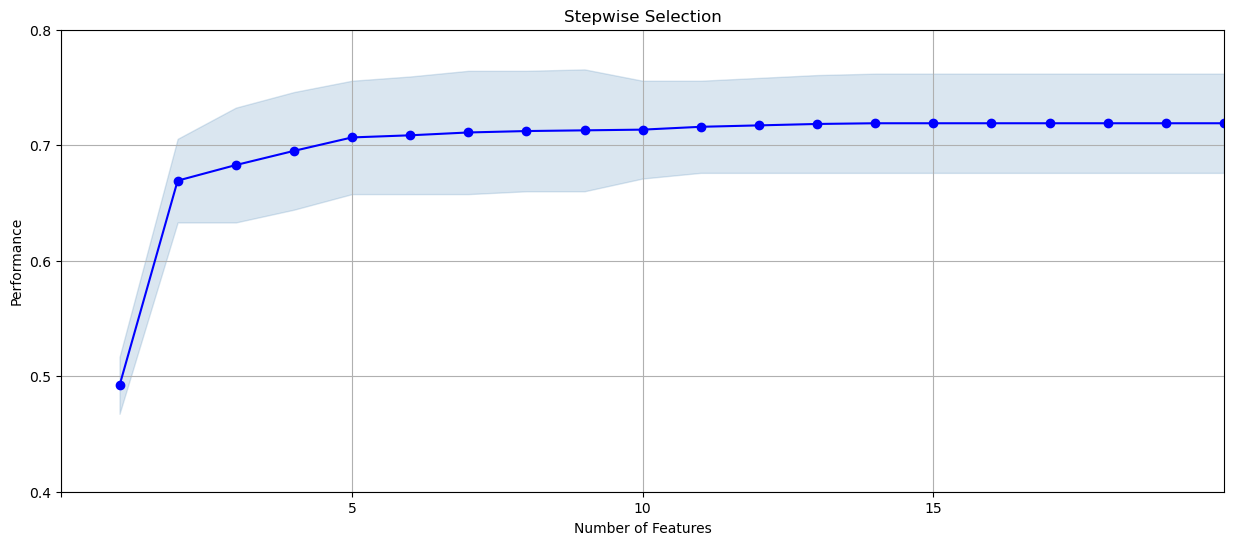

In [24]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, num_wrapper, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([.4,.8])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

## 7. Track and store the order in which variables were selected

In [25]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [26]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# I might also need this following line. It converts a list to a string
#         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [27]:
ordered_vars_FS

feature_idx  \
1                                               (25,)   
2                                           (25, 129)   
3                                       (25, 51, 129)   
4                                  (25, 51, 129, 151)   
5                              (17, 25, 51, 129, 151)   
6                          (17, 23, 25, 51, 129, 151)   
7                     (17, 23, 25, 51, 129, 151, 185)   
8                (17, 23, 25, 51, 129, 130, 151, 185)   
9            (17, 23, 25, 51, 58, 129, 130, 151, 185)   
10      (17, 23, 25, 51, 58, 129, 130, 151, 185, 206)   
11  (17, 23, 25, 51, 58, 129, 130, 151, 185, 198, ...   
12  (16, 17, 23, 25, 51, 58, 129, 130, 151, 185, 1...   
13  (16, 17, 23, 25, 33, 51, 58, 129, 130, 151, 18...   
14  (16, 17, 23, 25, 33, 51, 58, 129, 130, 151, 18...   
15  (15, 16, 17, 23, 25, 33, 51, 58, 129, 130, 151...   
16  (15, 16, 17, 21, 23, 25, 33, 51, 58, 129, 130,...   
17  (15, 16, 17, 21, 22, 23, 25, 33, 51, 58, 129, ...   
18  (15, 16, 17, 21, 22, 23, 25, 27, 33, 51, 58, 1...   
19  (15, 16, 17, 21, 22, 23, 25, 27, 30, 33, 51, 5...   
20  (15, 16, 17, 21, 22, 23, 25, 27, 30, 31, 33, 5...   

                                    cv_scores avg_score  \
1   [0.5165644171779141, 0.46748466257668714]  0.492025   
2    [0.7055214723926381, 0.6331288343558282]  0.669325   
3    [0.7325153374233129, 0.6331288343558282]  0.682822   
4    [0.7460122699386503, 0.6441717791411042]  0.695092   
5    [0.7558282208588957, 0.6576687116564417]  0.706748   
6    [0.7595092024539877, 0.6576687116564417]  0.708589   
7    [0.7644171779141105, 0.6576687116564417]  0.711043   
8     [0.7644171779141105, 0.660122699386503]   0.71227   
9     [0.7656441717791411, 0.660122699386503]  0.712883   
10   [0.7558282208588957, 0.6711656441717792]  0.713497   
11   [0.7558282208588957, 0.6760736196319018]  0.715951   
12    [0.758282208588957, 0.6760736196319018]  0.717178   
13   [0.7607361963190185, 0.6760736196319018]  0.718405   
14   [0.7619631901840491, 0.6760736196319018]  0.719018   
15   [0.7619631901840491, 0.6760736196319018]  0.719018   
16   [0.7619631901840491, 0.6760736196319018]  0.719018   
17   [0.7619631901840491, 0.6760736196319018]  0.719018   
18   [0.7619631901840491, 0.6760736196319018]  0.719018   
19   [0.7619631901840491, 0.6760736196319018]  0.719018   
20   [0.7619631901840491, 0.6760736196319018]  0.719018   

                                        feature_names  ci_bound   std_dev  \
1            (Cardnum_unique_count_for_card_state_1,)  0.105587   0.02454   
2   (Cardnum_unique_count_for_card_state_1, Card_M...   0.15574  0.036196   
3   (Cardnum_unique_count_for_card_state_1, Cardnu...  0.213813  0.049693   
4   (Cardnum_unique_count_for_card_state_1, Cardnu...  0.219092   0.05092   
5   (Card_dow_vdratio_0by60, Cardnum_unique_count_...  0.211173   0.04908   
6   (Card_dow_vdratio_0by60, Card_dow_vdratio_0by1...  0.219092   0.05092   
7   (Card_dow_vdratio_0by60, Card_dow_vdratio_0by1...  0.229651  0.053374   
8   (Card_dow_vdratio_0by60, Card_dow_vdratio_0by1...  0.224371  0.052147   
9   (Card_dow_vdratio_0by60, Card_dow_vdratio_0by1...  0.227011  0.052761   
10  (Card_dow_vdratio_0by60, Card_dow_vdratio_0by1...  0.182137  0.042331   
11  (Card_dow_vdratio_0by60, Card_dow_vdratio_0by1...  0.171578  0.039877   
12  (Card_dow_vdratio_0by30, Card_dow_vdratio_0by6...  0.176858  0.041104   
13  (Card_dow_vdratio_0by30, Card_dow_vdratio_0by6...  0.182137  0.042331   
14  (Card_dow_vdratio_0by30, Card_dow_vdratio_0by6...  0.184776  0.042945   
15  (Cardnum_total_14, Card_dow_vdratio_0by30, Car...  0.184776  0.042945   
16  (Cardnum_total_14, Card_dow_vdratio_0by30, Car...  0.184776  0.042945   
17  (Cardnum_total_14, Card_dow_vdratio_0by30, Car...  0.184776  0.042945   
18  (Cardnum_total_14, Card_dow_vdratio_0by30, Car...  0.184776  0.042945   
19  (Cardnum_total_14, Card_dow_vdratio_0by30, Car...  0.184776  0.042945   
20  (Cardnum_total_14, Card_dow_vdratio_0by30, Car...  0.184776 

## 8. Save the wrapper list into csv files

In [28]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [29]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1     Cardnum_unique_count_for_card_state_1
2              Card_Merchdesc_State_total_7
3                     Cardnum_count_1_by_30
4                            Cardnum_max_14
5                    Card_dow_vdratio_0by60
6                    Card_dow_vdratio_0by14
7               Merchnum_desc_State_total_3
8                    Card_Merchdesc_total_7
9     Card_dow_unique_count_for_merch_zip_7
10                      merch_state_total_1
11             Card_Merchnum_State_total_60
12                   Card_dow_vdratio_0by30
13      Cardnum_unique_count_for_card_zip_3
14              Merchnum_desc_State_total_1
15                         Cardnum_total_14
16                         Card_dow_count_7
17                    Cardnum_actual/toal_0
18                        Card_dow_total_30
19                    Card_dow_vdratio_0by7
20                     Cardnum_vdratio_1by7
Name: variable name, dtype: object

In [30]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

filter score
variable                                                        
Cardnum_total_3                                         0.621932
Cardnum_total_1                                         0.619658
Cardnum_total_0                                         0.591318
Cardnum_count_1                                         0.567429
Cardnum_total_7                                         0.564245
...                                                          ...
Card_Merchdesc_Zip_unique_count_for_Merchdesc_S...      0.000038
merch_zip_unique_count_for_merch_state_14               0.000025
Merchnum_desc_Zip_unique_count_for_Merchnum_des...      0.000013
merch_zip_unique_count_for_merch_state_7                0.000013
card_merch_unique_count_for_Cardnum_1                   0.000000

[2634 rows x 1 columns]

In [31]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

Empty DataFrame
Columns: []
Index: [Cardnum_unique_count_for_card_state_1, Card_Merchdesc_State_total_7, Cardnum_count_1_by_30, Cardnum_max_14, Card_dow_vdratio_0by60]

In [32]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [33]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

wrapper order                               variable  filter score
0               1  Cardnum_unique_count_for_card_state_1      0.476067
1               2           Card_Merchdesc_State_total_7      0.324668
2               3                  Cardnum_count_1_by_30      0.428229
3               4                         Cardnum_max_14      0.318826
4               5                 Card_dow_vdratio_0by60      0.486480
5               6                 Card_dow_vdratio_0by14      0.479086
6               7            Merchnum_desc_State_total_3      0.308586
7               8                 Card_Merchdesc_total_7      0.324631
8               9  Card_dow_unique_count_for_merch_zip_7      0.418943
9              10                    merch_state_total_1      0.304893
10             11           Card_Merchnum_State_total_60      0.305385
11             12                 Card_dow_vdratio_0by30      0.489227
12             13    Cardnum_unique_count_for_card_zip_3      0.464323
13             14            Merchnum_desc_State_total_1      0.304969
14             15                       Cardnum_total_14      0.494375
15             16                       Card_dow_count_7      0.482384
16             17                  Cardnum_actual/toal_0      0.479550
17             18                      Card_dow_total_30      0.474759
18             19                  Card_dow_vdratio_0by7      0.467961
19             20                   Cardnum_vdratio_1by7      0.466766

In [34]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_State_total_7',
 'Cardnum_count_1_by_30',
 'Cardnum_max_14',
 'Card_dow_vdratio_0by60',
 'Card_dow_vdratio_0by14',
 'Merchnum_desc_State_total_3',
 'Card_Merchdesc_total_7',
 'Card_dow_unique_count_for_merch_zip_7',
 'merch_state_total_1',
 'Card_Merchnum_State_total_60',
 'Card_dow_vdratio_0by30',
 'Cardnum_unique_count_for_card_zip_3',
 'Merchnum_desc_State_total_1',
 'Cardnum_total_14',
 'Card_dow_count_7',
 'Cardnum_actual/toal_0',
 'Card_dow_total_30',
 'Card_dow_vdratio_0by7',
 'Cardnum_vdratio_1by7',
 'Recnum',
 'Fraud']

In [35]:
filter_score

filter score
variable                                                        
Cardnum_total_3                                         0.621932
Cardnum_total_1                                         0.619658
Cardnum_total_0                                         0.591318
Cardnum_count_1                                         0.567429
Cardnum_total_7                                         0.564245
...                                                          ...
Card_Merchdesc_Zip_unique_count_for_Merchdesc_S...      0.000038
merch_zip_unique_count_for_merch_state_14               0.000025
Merchnum_desc_Zip_unique_count_for_Merchnum_des...      0.000013
merch_zip_unique_count_for_merch_state_7                0.000013
card_merch_unique_count_for_Cardnum_1                   0.000000

[2634 rows x 1 columns]

In [36]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 20.3 s, sys: 3.59 s, total: 23.9 s
Wall time: 25.9 s


(97496, 2635)

In [37]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(97496, 22)


In [38]:
df_keep.to_csv('vars_final.csv',index=False)

In [39]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:06:59.807521


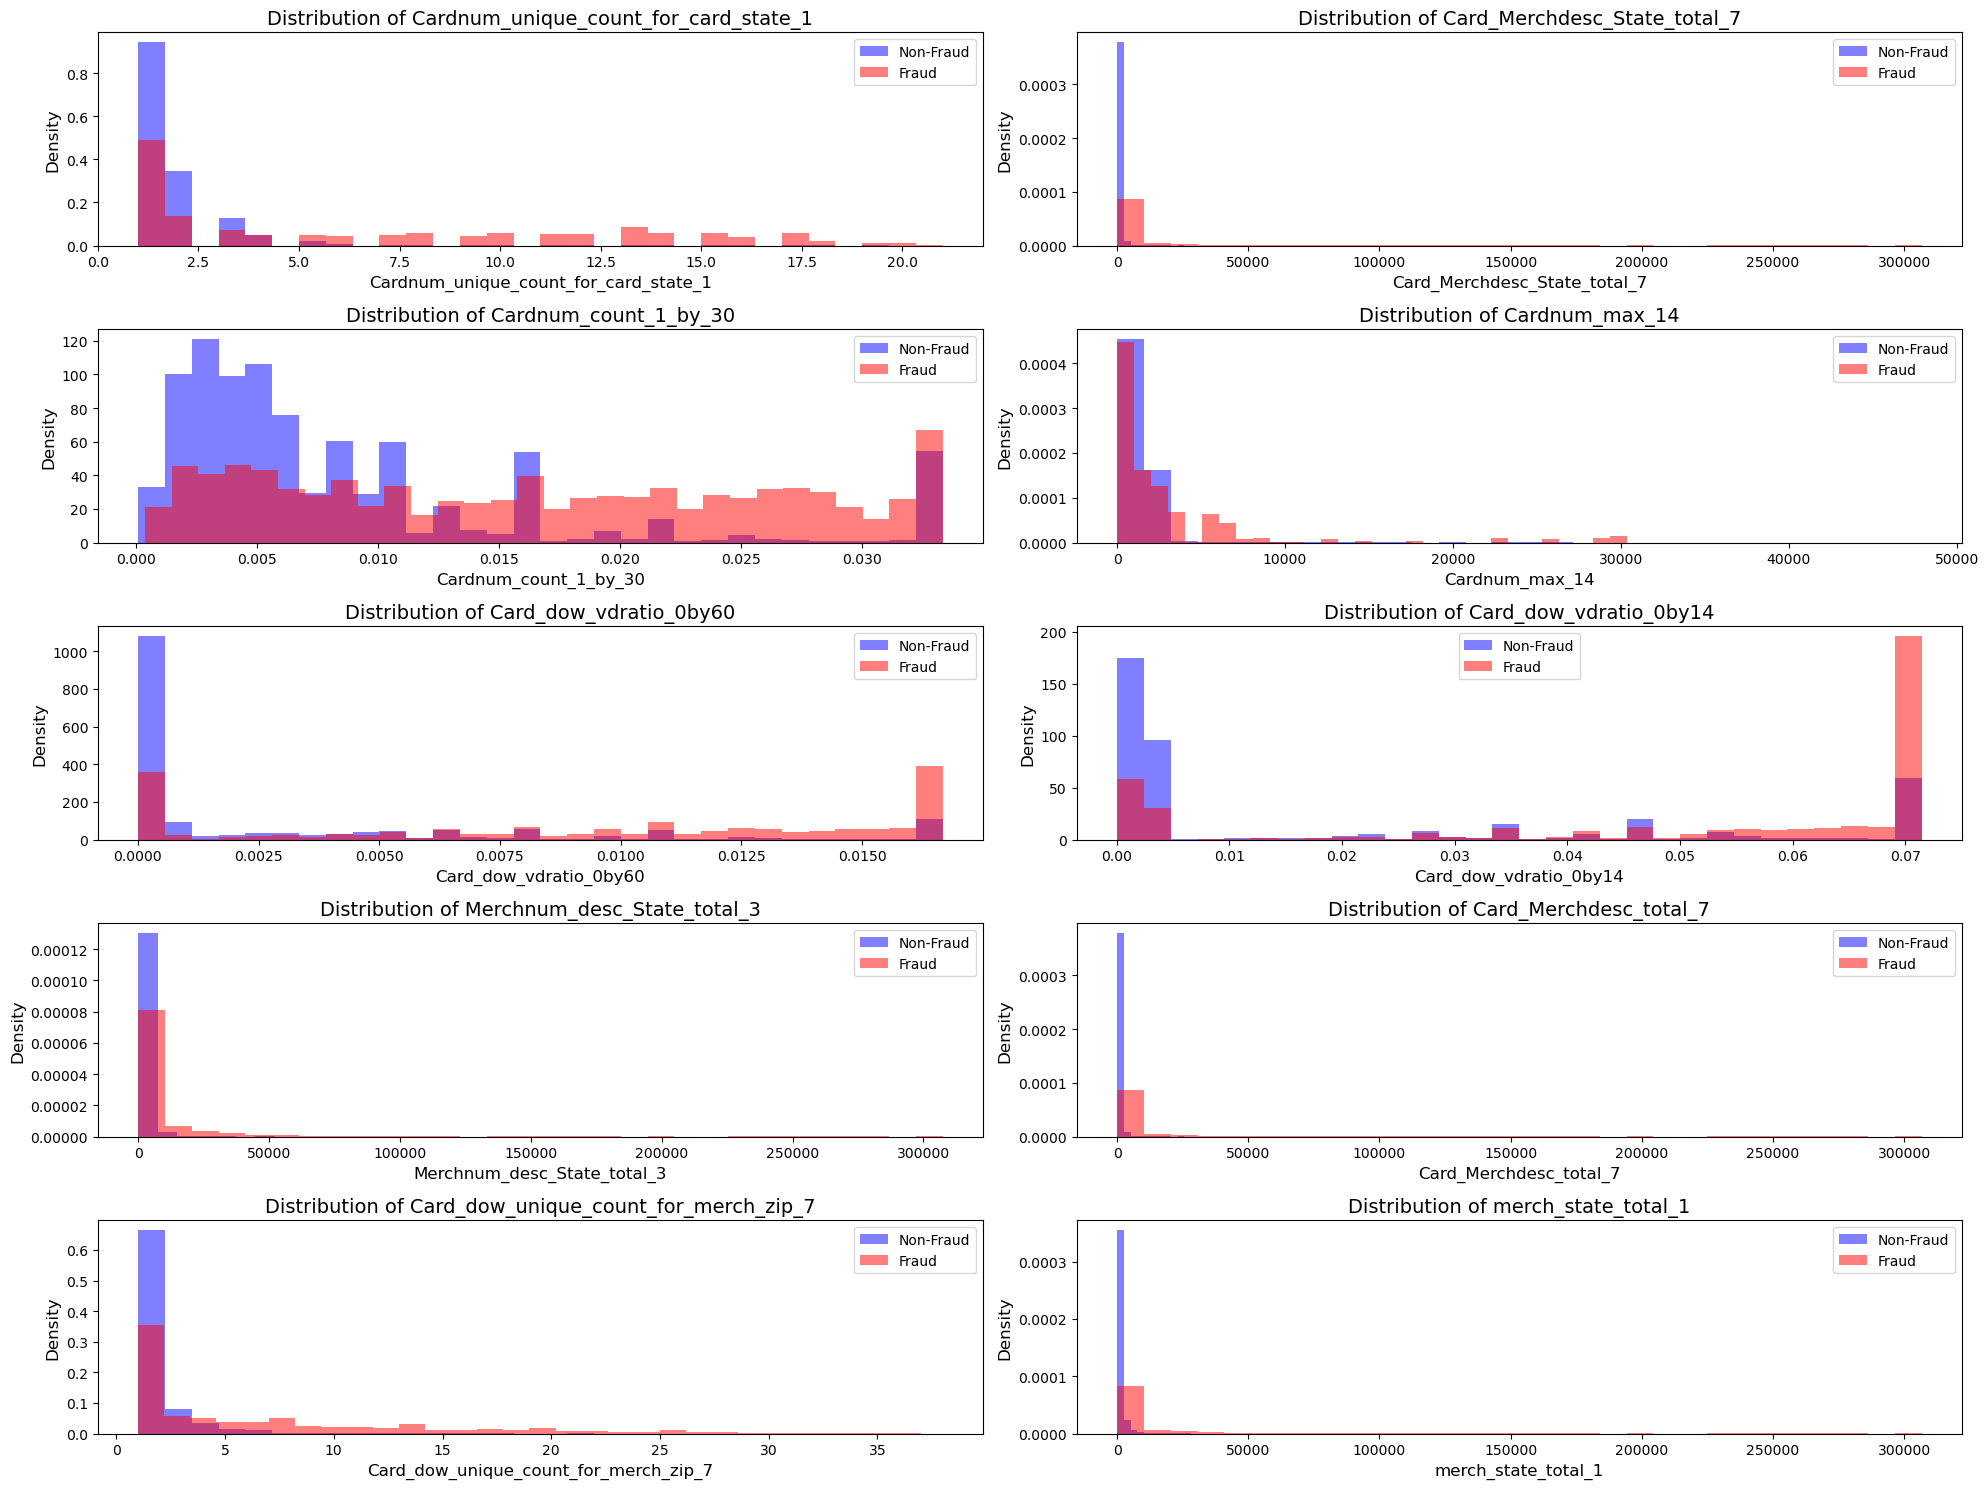

In [46]:
# Load the vars_keep_sorted.csv file to get the final list of 20 features
vars_keep_sorted = pd.read_csv('vars_keep_sorted.csv')

# Get the final list of 20 features
top_20_features = vars_keep_sorted['variable'][:20].tolist()

# Load the final dataset after feature selection
df_final = pd.read_csv('vars_final.csv')

# Separate the data into good (non-fraud) and bad (fraud) labels
goods = df_final[df_final[y_name] == good_label]
bads = df_final[df_final[y_name] == bad_label]

# Plot the first 10 features
plt.figure(figsize=(20, 15))
for i, feature in enumerate(top_20_features[:10], 1):
    plt.subplot(5, 2, i)  # Create a 5x2 grid for 10 plots
    plt.hist(goods[feature], bins=30, alpha=0.5, label='Non-Fraud', color='blue', density=True)
    plt.hist(bads[feature], bins=30, alpha=0.5, label='Fraud', color='red', density=True)
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(f'{feature}', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()

plt.tight_layout()
plt.show()

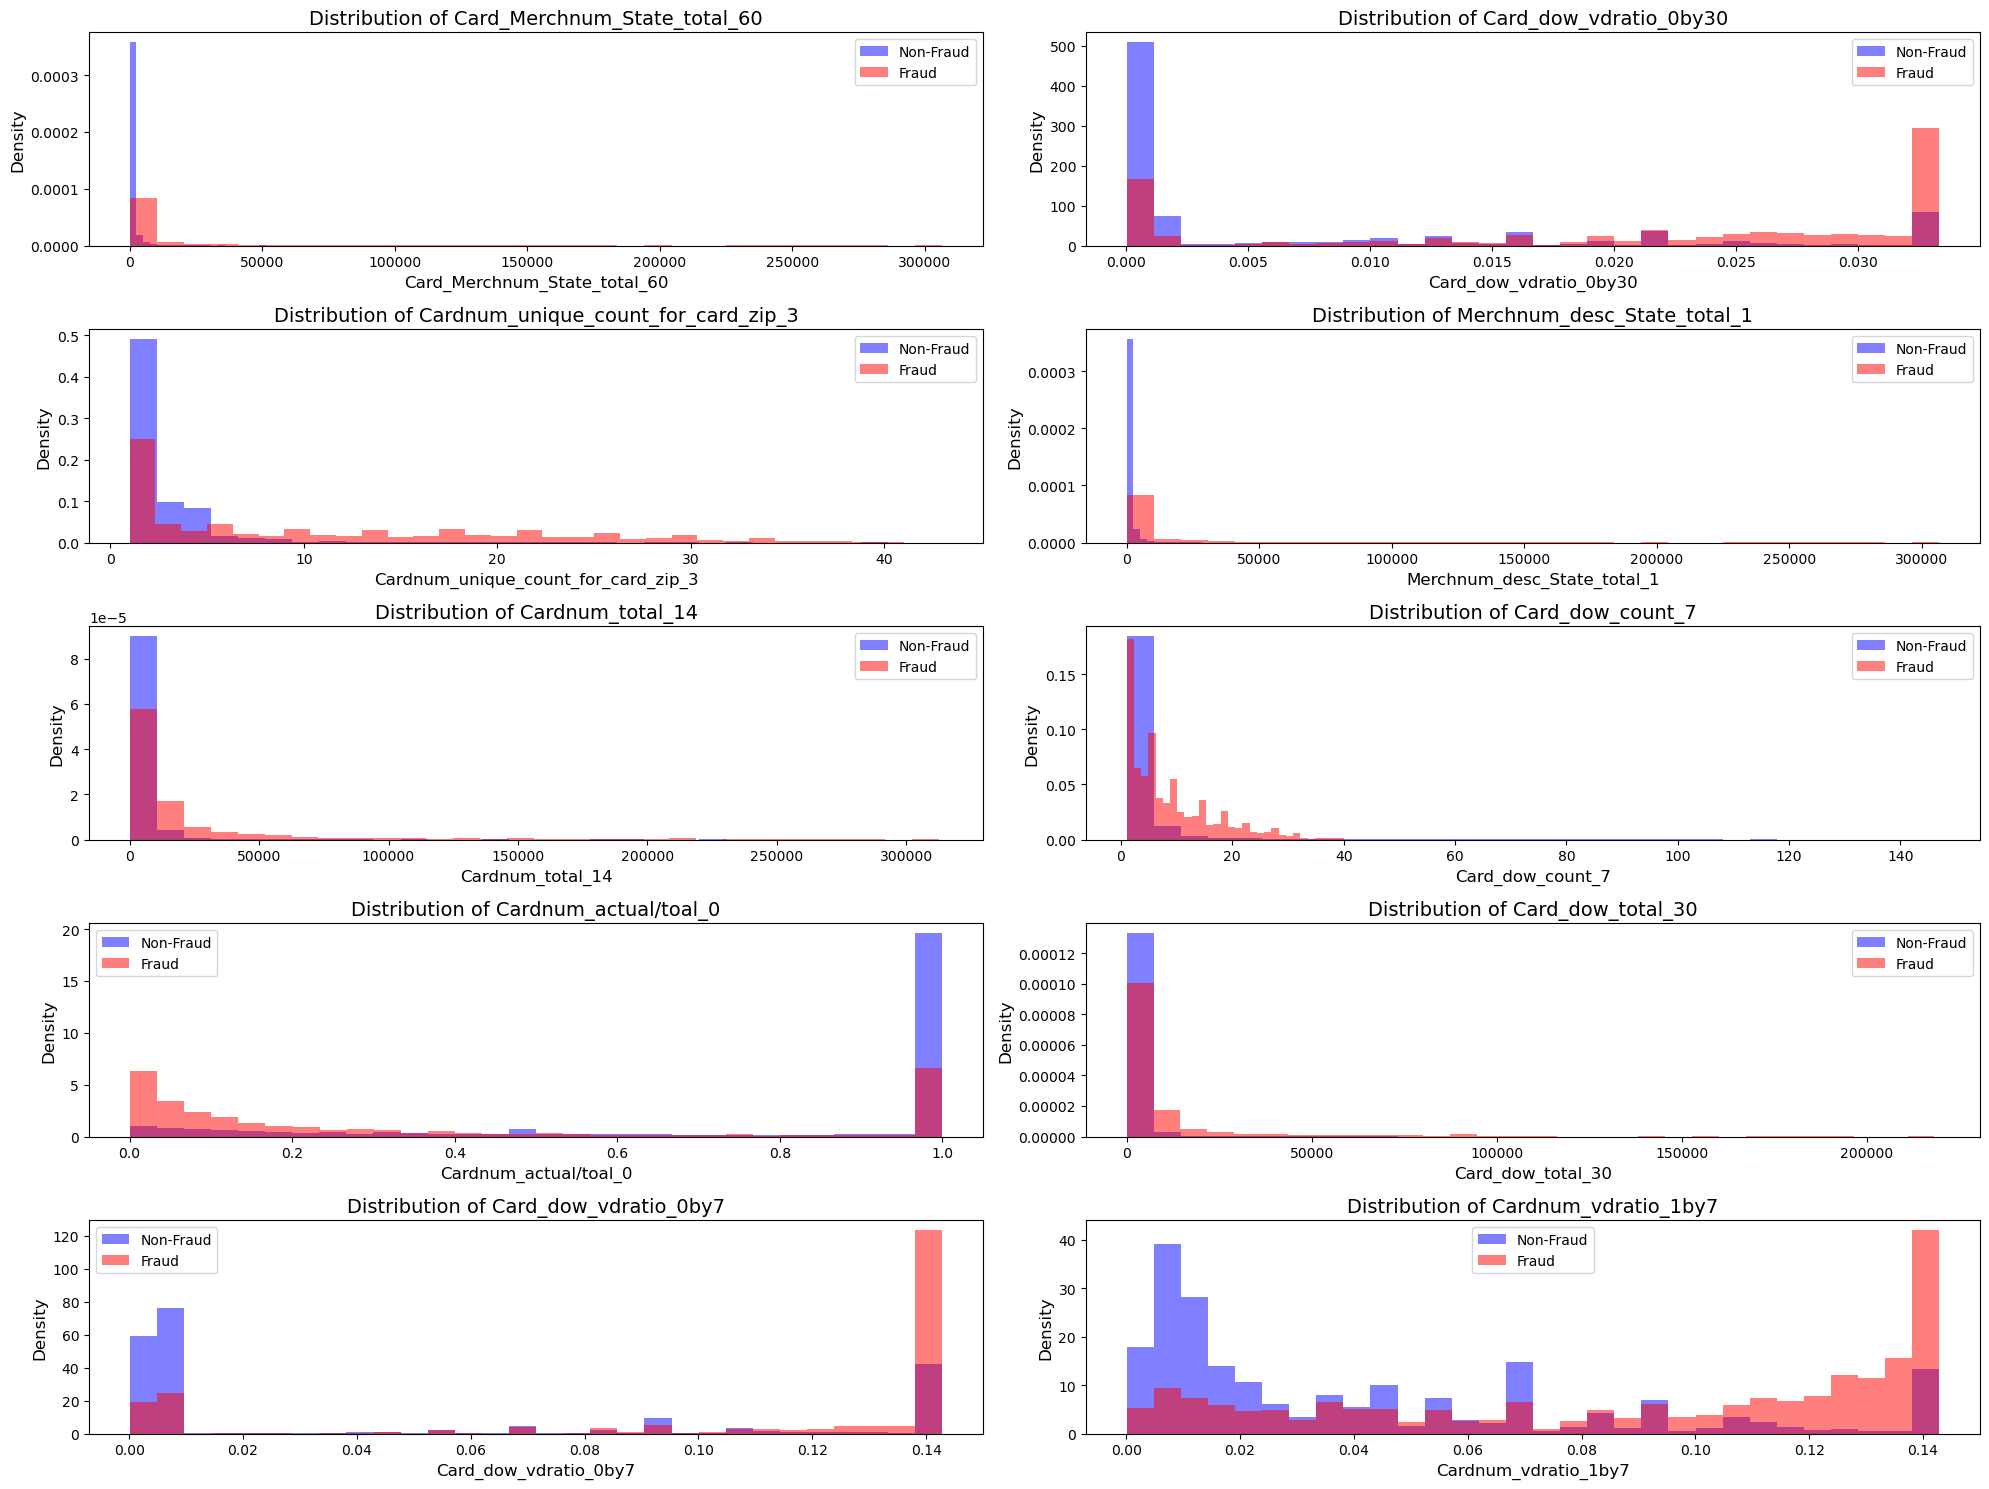

In [47]:
# Plot the next 10 features
plt.figure(figsize=(20, 15))
for i, feature in enumerate(top_20_features[10:], 1):
    plt.subplot(5, 2, i)  # Create another 5x2 grid for the remaining 10 plots
    plt.hist(goods[feature], bins=30, alpha=0.5, label='Non-Fraud', color='blue', density=True)
    plt.hist(bads[feature], bins=30, alpha=0.5, label='Fraud', color='red', density=True)
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(f'{feature}', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()

plt.tight_layout()
plt.show()